In [1]:
%load_ext autoreload
%autoreload 2

import os
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from vr2f.eyetracking import et_plot_gaze_saccades, et_utils, ms_toolbox
from vr2f.staticinfo import COLORS, CONSTANTS, PATHS, TIMINGS

paths = PATHS()
colors = COLORS()
constants = CONSTANTS()
cm = constants.CM
timings = TIMINGS()

In [2]:
def plot_image(av_name, emotion, ax, invert=False, alpha=1):
  img = plt.imread(Path(paths.STIMULIIMAGES, f"{av_name}_{emotion.capitalize()}.png"))
  cutval = 205
  im2 = img[cutval + 35 : -cutval, cutval + 35 : -cutval, :]
  height, width, _ = im2.shape
  # Overlay the image onto the plot, centered on the axes
  origin = "lower" if invert else "upper"
  ax.imshow(im2, extent=[-5, 5, -5, 5], alpha=alpha, origin=origin)

In [8]:
# read in the preprocessed data
pattern = "preproc.csv"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

You can plot the supplementary figures to visualize the gaze and the detected saccades for specific trials like this: 

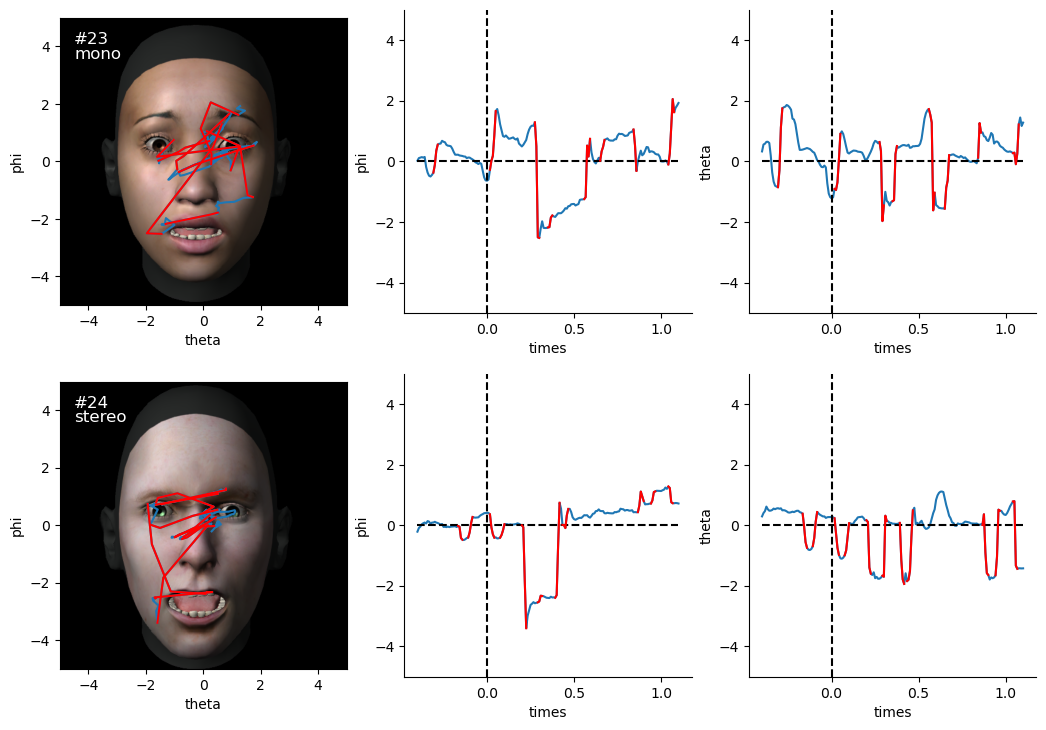

In [9]:

sub_id = "VR2FEM_S01"
trial_range = range(23, 25)


myfig = et_plot_gaze_saccades.plot_gaze_sacc_per_trial(df_all, sub_id, trial_range, sfreq=120)


To render PDFs (`results/figures/ET/Gaze_saccades`) with all trials for a given subject (or all of them), use the bash functionality of `et_plot_gaze_saccades.py` (ideally with the slurm script in `/code/HPC`). 

In [10]:

def get_sacc_fix_per_sub(args):
    df_all, trial_range, sub_id = args 

    sfreq = constants.SFREQ_ET
    vfac = constants.ET_SACC_VFAC
    mindur = constants.ET_SACC_MINDUR

    df_sub = df_all.query("sub_id == @sub_id").copy()
    df_gaze_subject = pd.DataFrame()

    sacs = pd.DataFrame()
    for trial_idx in trial_range:
        df_st = et_plot_gaze_saccades.get_data_sub_trialnum(df_sub, sub_id, trial_idx)
        if df_st.empty:
            print(f"!!! Warning: No data for {sub_id} and trial {trial_idx}. Skipping this trial.")
            continue
        data = df_st.loc[:,["theta", "phi"]].to_numpy()
        sac, rad = ms_toolbox.microsacc(data, srate=sfreq, vfac=vfac, mindur=mindur)
        sac["trial_num"] = trial_idx
        sacs = pd.concat([sacs, sac], ignore_index=True)
        df_st["gaze_state"] = "fix"
        df_st["idx_fix"] = 0
        for i, row in sac.iterrows():
            onset = row["idx_onset"]
            offset = row["idx_offset"]
            df_st.loc[onset:offset+1, ["gaze_state"]] = "sacc"
            df_st.loc[onset:offset+1, ["idx_sacc"]] = i
            df_st.loc[offset:, "idx_fix"] = i+1
        df_gaze_subject = pd.concat([df_gaze_subject, df_st], ignore_index=True)
    sacs["sub_id"] = sub_id
    df_gaze_subject["idx_sacc"] = df_gaze_subject["idx_sacc"].fillna(-99)
    df_gaze_subject["idx_sacc"] = df_gaze_subject["idx_sacc"].astype(int)
    return (df_gaze_subject, sacs)

## Set up parallelization across subjects

# Choose subjects
sub_id_selection = sub_list_str_et
num_processes = len(sub_id_selection)

# Prepare input
trial_range = range(1, 745) # all trials

args_list = [(df_all, trial_range, sub_id) for sub_id in sub_id_selection]

# Run it on pool
pool = Pool(processes=num_processes)
results = pool.map(get_sacc_fix_per_sub, args_list)
pool.close()
pool.join()


!!! Warning: No data for VR2FEM_S31 and trial 512. Skipping this trial.


In [11]:

# Combine results for all subjects and write to disk
df_gaze = pd.concat([res[0] for res in results], ignore_index=True)
fpath = paths.DATA_ET / "02_gaze"
fpath.mkdir(exist_ok=True, parents=True)
df_gaze.to_csv(Path(fpath, "gaze_all.csv"), index=False)




## Saccades 

We do the same for the saccades DF, but first we add columns with the onset and offset time of the saccade:

In [33]:
saccades = pd.concat([res[1] for res in results], ignore_index=True)

# get sacc start and end times:
sacc_times = (df_gaze
                .query("gaze_state == 'sacc'")
                .groupby(["sub_id", "trial_num", "idx_sacc"], as_index=False)
                .agg({"times": ["first", "last"]})
                .reset_index()
             )
sacc_times.columns = list(map("".join, sacc_times.columns))
sacc_times.columns = (sacc_times.rename(columns= {"timesfirst": "times_onset", 
                                         "timeslast": "times_offset"})
                                .columns
                     )

saccades = (saccades
              .assign(idx_sacc = lambda x:
                        (x.groupby(["sub_id", "trial_num"])
                          .cumcount()
                        )
                      )
              .merge(sacc_times.drop(["index"], axis=1),
                     on=["sub_id", "trial_num", "idx_sacc"])
           )

saccades["amp_tot"] = np.sqrt(saccades["vec_x"]**2 + saccades["vec_y"]**2)
saccades["angle"] = (saccades
                      .apply(lambda x: et_utils.angle_from_spherical(x.vec_x, x.vec_y), axis=1)
)



In [34]:
fpath = paths.DATA_ET / "02_gaze"
fpath.mkdir(exist_ok=True, parents=True)
saccades.to_csv(Path(fpath, "saccades_all.csv"), index=False)

## Fixations

Now for fixations adding info about the fixation specs:

In [70]:

fixations = (df_gaze
  .query("gaze_state == 'fix'")
  .groupby(["sub_id", "trial_num", "gaze_state", "idx_fix"], as_index=False)
  .agg({"times": ["first", "last"],
        "theta": ["mean", "min", "max"],
        "phi": ["mean", "min", "max"]})
  .reset_index()
)
fixations.columns = list(map("".join, fixations.columns))
fixations.columns = (fixations.rename(columns={"timesfirst": "times_onset", "timeslast":
                                              "times_offset", "thetamean": "center_theta",
                                              "thetamin": "min_theta", "thetamax": "max_theta",
                                              "phimean": "center_phi", "phimin": "min_phi",
                                              "phimax": "max_phi"})
                              .columns
                    )
fixations["duration"] = fixations["times_offset"] - fixations["times_onset"]
fixations["spread_theta"] = fixations["max_theta"] - fixations["min_theta"]
fixations["spread_phi"] = fixations["max_phi"] - fixations["min_phi"]


In [71]:
fpath = paths.DATA_ET / "02_gaze"
fpath.mkdir(exist_ok=True, parents=True)
fixations.to_csv(Path(fpath, "fixations_all.csv"), index=False)

# Analyses

Now we run some analyses and plotting on the saccade and fixation data. 

To skip the preprocessing, saccade extraction, etc., you can directly load the data frames from disk.

In [35]:
load_data_from_disk = True

if load_data_from_disk:
    fpath = paths.DATA_ET / "02_gaze"
    saccades = pd.read_csv(Path(fpath, "saccades_all.csv"))
    fixations = pd.read_csv(Path(fpath, "fixations_all.csv"))
    df_gaze = pd.read_csv(Path(fpath, "gaze_all.csv"))

### Plotting parameters:

In [4]:
palette = colors.COLDICT

# Set this to False if yu do not want to overwrite
save_fig = True

## Fixation analyses

First, we plot the average gaze (per participant and trial) to make sure that we did not do something horrible when subtracting these values in the fashion of "baselining" to correct for drift in the tracking (e.g. due to slippage).

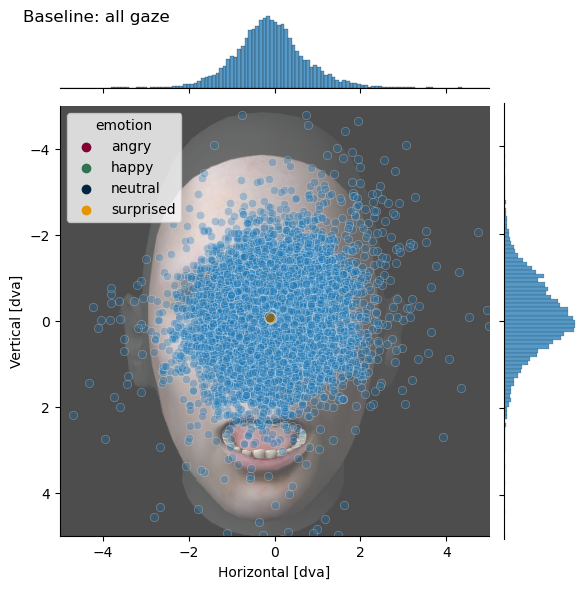

In [10]:
# A DF with the "baseline" for pitch and yaw (which we subtracted earlier):
baseline_df = (df_gaze
                .groupby(["sub_id", "trial_num"], as_index=False)
                .first()
                .loc[:, ["sub_id", "trial_num", "theta_baseline", "phi_baseline", "emotion"]]
)

# Baseline diagnostics:
fpath = Path(paths.FIGURES, "ET", "fixations", "diagnostics")
with PdfPages(Path(fpath, "gaze_baseline.pdf")) as pdf:
  g = sns.jointplot(data=baseline_df, x="theta_baseline", y="phi_baseline", palette=palette,
                    alpha=0.3)
  g.fig.axes[0].set_ylim(-5, 5)
  g.fig.axes[0].set_xlim(-5, 5)
  g.fig.axes[0].set_xlabel("Horizontal [dva]")
  g.fig.axes[0].set_ylabel("Vertical [dva]")
  g.fig.suptitle("Baseline: all gaze", x=0.05, ha="left")
  g.fig.axes[0].invert_yaxis()

  plot_image(av_name = "Woman_08", emotion = "angry", ax=g.fig.axes[0], invert=True, alpha=0.7)

  baseline_df_sum = (baseline_df
                        .groupby(["emotion"], as_index=False)
                        .agg({"theta_baseline": "mean", "phi_baseline": "mean"})
                    )
  sns.scatterplot(data=baseline_df_sum, x="theta_baseline", y="phi_baseline", hue="emotion",
                   palette=palette, ax=g.fig.axes[0], s=60, alpha=0.45)

  if save_fig:
    pdf.savefig(g.fig)



Looks pretty ok! There is some variance also during the baseline, but almost all of it takes palce within +/- 2 dva from the fixation cross. and everything (importantly also the condition averages) is neatly centered.   

Next, let's sort the fixations into three categories (as inspired by [Spiering & Dimigen, 2023](https://olaf.dimigen.de/papers/Spiering.Dimigen.2023.MicrosaccFaces.pdf)):

1. Baseline
2. First Fixation (after stimulus onset; i.e., we're not counting fixations which already started before the stimulus was visible)
3. Later fixation: all fixations which occured later in the trial 

For all fixations we enforce a minimal duration of 50ms to be counted.

In [11]:
# A DF with the design matrix:
design_df = (df_gaze
              .loc[:, ["sub_id", "trial_num", "emotion", "viewcond", "avatar_id"]]
              .drop_duplicates()
)

cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

# fixation must last at least 50ms
fix_mindur = constants.ET_FIX_MINDUR
baseline = (-1 * timings.DUR_BL, 0.0)
fixations_baseline = (fixations
                        .query("times_onset < @baseline[0] & \
                                times_onset < @baseline[1] & \
                                  duration > @fix_mindur")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

fixations_first = (fixations
                    .query("times_onset > 0 & duration > @fix_mindur")
                    .groupby(["sub_id", "trial_num"], as_index=False)
                    .first()
                    .merge(design_df, on=["sub_id", "trial_num"])
)

tmp_offsets = fixations_first.loc[:,["times_offset", "trial_num"]]

fixations_later = (fixations
                     .merge(tmp_offsets, on=["trial_num"], suffixes=("", "_first"))
                     .query("times_onset > times_offset_first & duration > @fix_mindur")
                     .merge(design_df, on=["sub_id", "trial_num"])
)

Now we can plot the fixations (per trial and emotion).

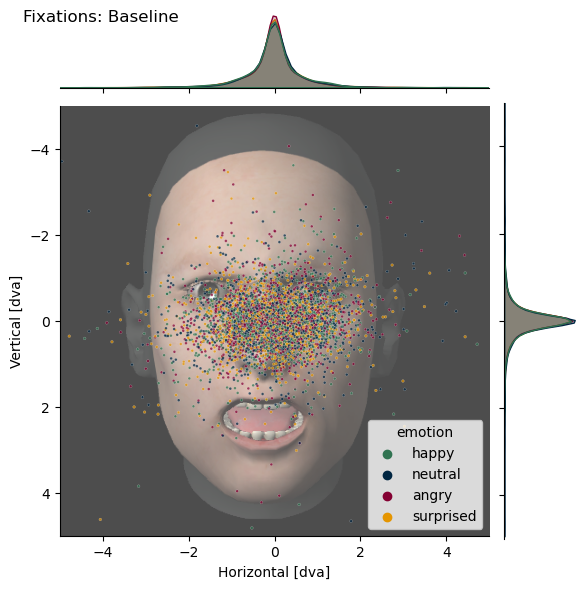

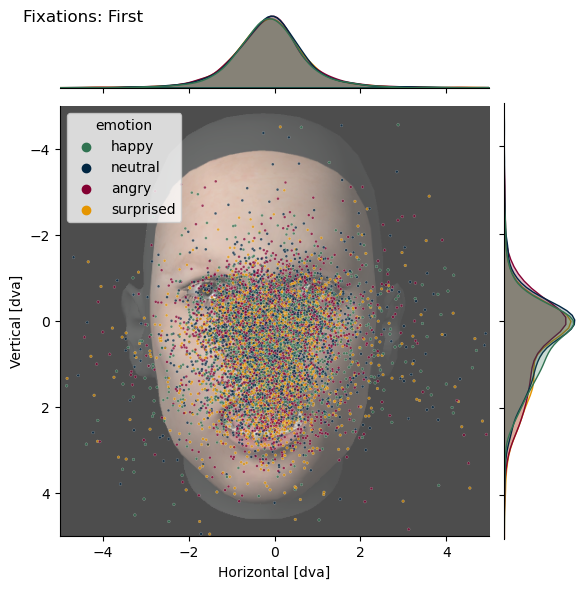

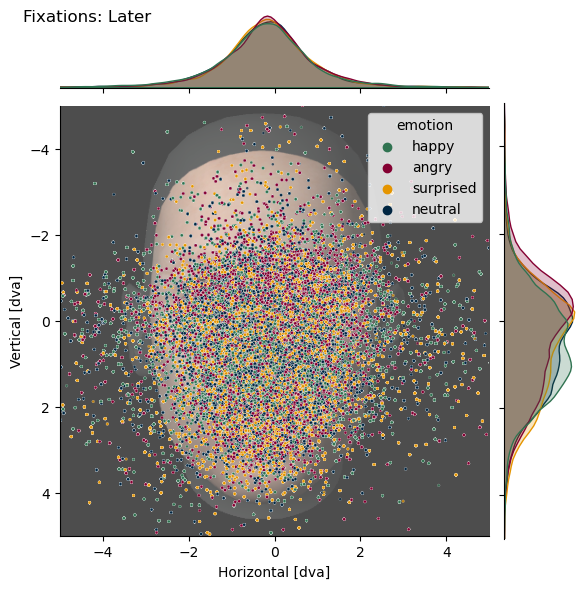

In [12]:
# Fixation diagnostics
fpath = Path(paths.FIGURES, "ET", "fixations")
fpath.mkdir(parents=True, exist_ok=True)

with PdfPages(Path(fpath, "fixations_per_stage.pdf")) as pdf:
  for df, title in zip((fixations_baseline, fixations_first, fixations_later),
                       ("Baseline", "First", "Later"), strict=True):
    g = sns.jointplot(data=df, x="center_theta", y="center_phi", hue="emotion", palette=palette,
                      alpha=0.7, kind="scatter", s=4)
    g.fig.suptitle(f"Fixations: {title}", x=0.05, ha="left")
    g.fig.axes[0].set_ylim(-5, 5)
    g.fig.axes[0].set_xlim(-5, 5)
    g.fig.axes[0].set_xlabel("Horizontal [dva]")
    g.fig.axes[0].set_ylabel("Vertical [dva]")
    g.fig.axes[0].invert_yaxis()

    plot_image(av_name = "Woman_04", emotion = "angry", ax=g.fig.axes[0], invert=True, alpha=0.7)

    if save_fig:
      pdf.savefig(g.fig)


This gives a useful first overview.  
1. Baselining did what it was supposed to do.
2. The first fixations are spread out in the eyes-to-mouth region. 
3. later fixations cover the entire face.
4. Anything "interesting" in contrasting emotion condition seems to happen along the vertical axis. 

Let us now plot heat maps separately for each emotion condition:


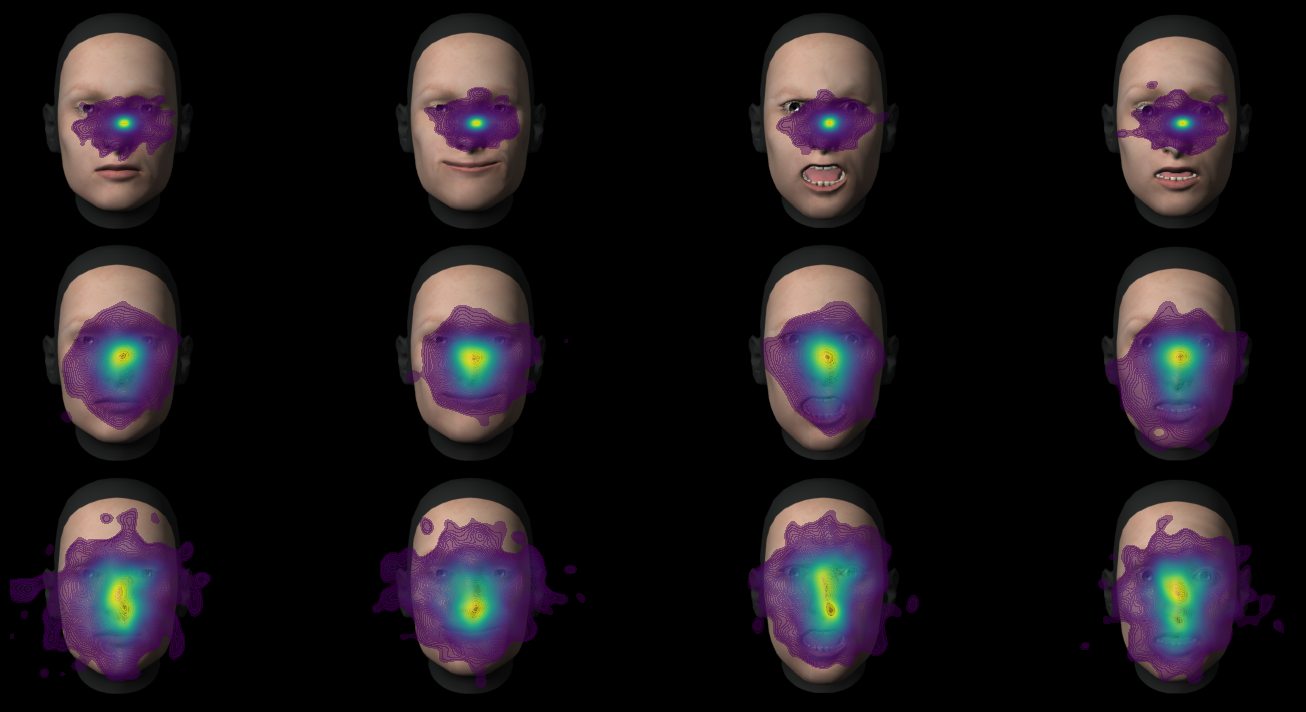

In [13]:
# sub_id_plt = "VR2FEM_S10"
img = plt.imread(Path(paths.STIMULIIMAGES, "Woman_08_Angry.png"))
im2 = img[245:-245, 245:-245, :]
height, width, _ = im2.shape

fig, axs = plt.subplots(3, 4, figsize=(18, 9))
# set the figure background to black
fig.patch.set_facecolor("black")
fig.patch.set_alpha(1.0)
# set the axes background to black
for ax in axs.flatten():
    ax.patch.set_facecolor("black")
    ax.patch.set_alpha(1.0)
# reduce the space between the subplots
fig.subplots_adjust(hspace=0.02, wspace=0.05)

for time_idx, data_fix in enumerate([fixations_baseline, fixations_first, fixations_later]):  
    for av_idx, av_name in enumerate(list(cond_dict["avatar_id"].values())[1:2]):  # noqa: B007
        for emo_idx, emotion in enumerate(cond_dict["emotion"].values()):
            ax = axs[time_idx, emo_idx]
            data_plot = (
                data_fix
                .query("emotion == @emotion")
                .query("avatar_id == @av_name")
                # .query("viewcond == @viewcond")
                # .query(f"sub_id == '{sub_id_plt}'")
            )

            # flip phi so that negative angles go downwards
            data_plot["center_phi"] = data_plot["center_phi"].apply(lambda x: x * -1)

            g = sns.kdeplot(
                data=data_plot,
                x="center_theta",
                y="center_phi",
                fill=True,
                cmap="viridis",
                levels=100,
                thresh=0.05,
                alpha=0.45,
                ax=ax,
            )

            ax.invert_yaxis()

            img = plt.imread(Path(paths.STIMULIIMAGES, f"{av_name}_{emotion.capitalize()}.png"))
            cutval = 205
            im2 = img[cutval + 35 : -cutval, cutval + 35 : -cutval, :]
            height, width, _ = im2.shape
            # Overlay the image onto the plot, centered on the axes
            ax.imshow(im2, extent=[-5, 5, -5, 5], alpha=1)
            # hide the axes and the ticks and labels
            ax.axis("off")

# save as pdf
fpath = Path(paths.FIGURES, "ET", "fixations")
if not fpath.exists():
    fpath.mkdir(parents=True)
plt.savefig(Path(fpath, f"fixations_heatmaps_all.pdf"), dpi=300, bbox_inches="tight", pad_inches=0)

Nice! It looks like especially the later (2nd onwards) fixations make a difference between the emotion conditions.

## Saccades

We first plot the a circular histogram ("polar shot") of the detected saccades — we then do the same for each emotion condition separately, to get an impression whether they differ. 

In [33]:
sacc_minamp = constants.ET_SACC_MINAMP

saccades_baseline = (saccades
                        .query("times_onset < @baseline[0] & \
                                times_onset < @baseline[1] & \
                                  amp_tot > @sacc_minamp")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

saccades_first = (saccades
                    .query("times_onset > 0 & amp_tot > @sacc_minamp")
                    .groupby(["sub_id", "trial_num"], as_index=False)
                    .first()
                    .merge(design_df, on=["sub_id", "trial_num"])
)

tmp_offsets = saccades_first.loc[:,["times_offset", "trial_num"]]

saccades_later = (saccades
                     .merge(tmp_offsets, on=["trial_num"], suffixes=("", "_first"))
                     .query("times_onset > times_offset_first & amp_tot > @sacc_minamp")
                     .merge(design_df, on=["sub_id", "trial_num"])
)

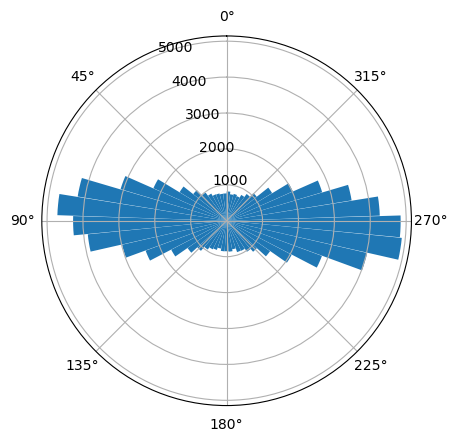

In [19]:
ax = plt.subplot(111, polar=True)

# bin the saccades in 50 bins
bins = np.linspace(0, 2*np.pi, 50)
saccades["angle_bin"] = pd.cut(saccades["angle"], bins, right=False)
saccades["bin_center"] = saccades["angle_bin"].apply(lambda x: x.mid)
sacc_plt = saccades.groupby(["bin_center"]).agg({"amp_tot": "count"}).reset_index()
bars = ax.bar(sacc_plt["bin_center"], sacc_plt["amp_tot"], bottom=0, width=(2*np.pi / 50))
ax.set_theta_offset(np.pi/2)


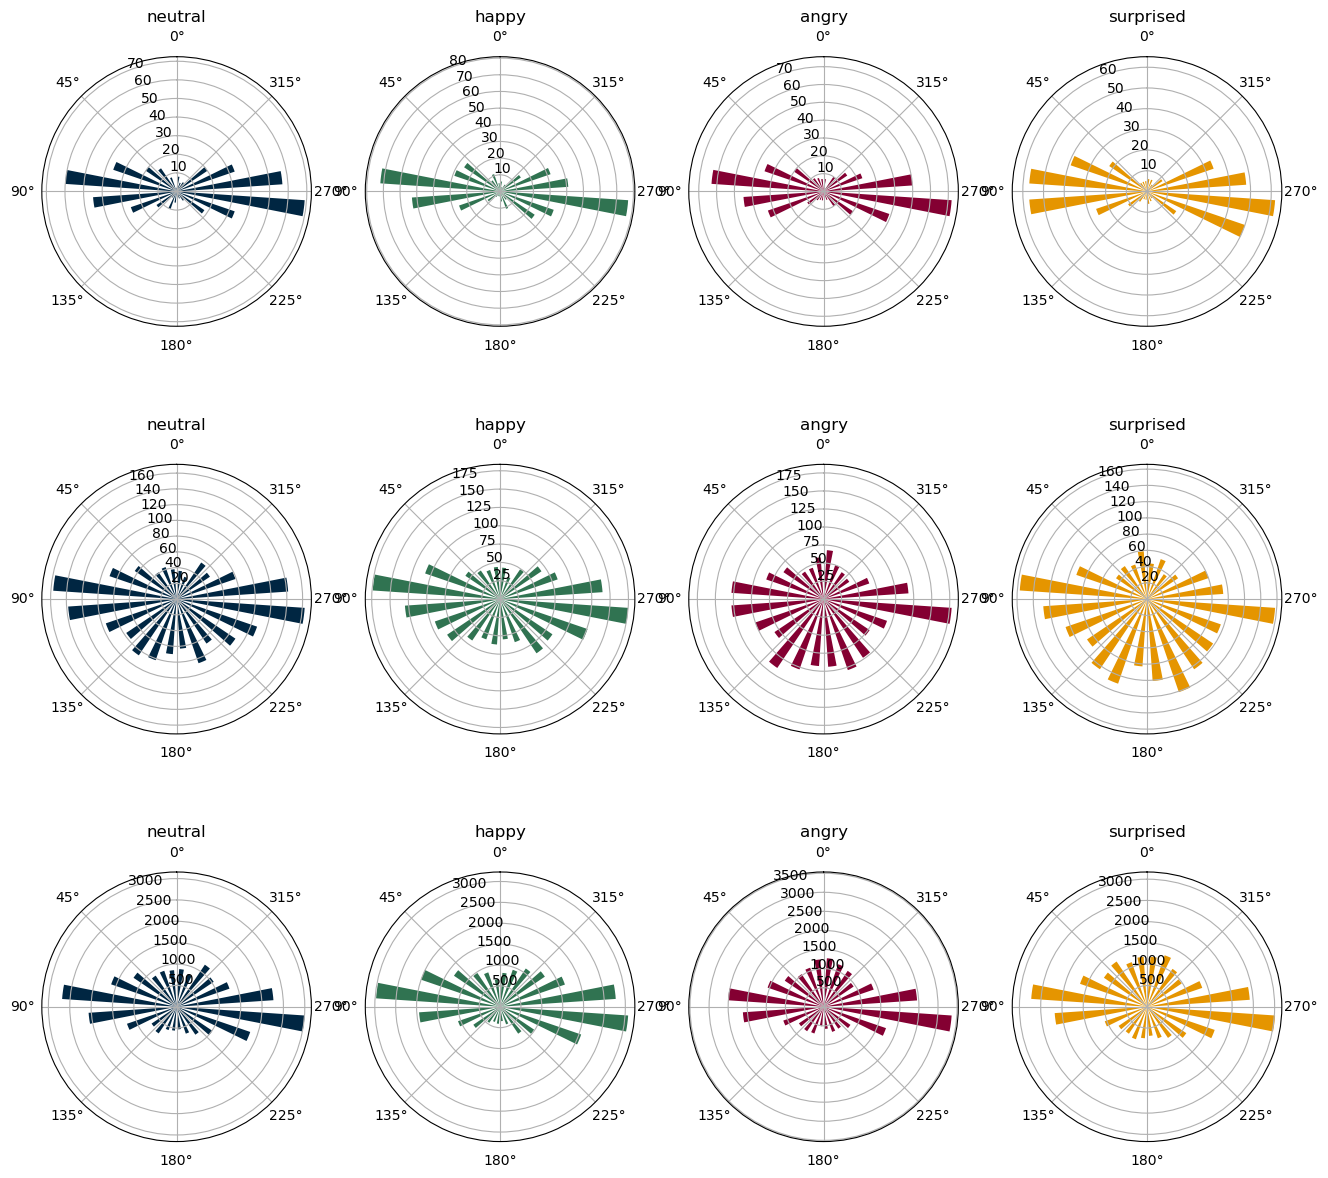

In [48]:
fig, axs = plt.subplots(3,4, subplot_kw=dict(polar=True), figsize=(16,15))
ylims_stage = [(0, 80),  # baseline
               (0, 175),  # first sacc
               (0, 3500)  # later sacc
              ]

for idx_stage, sacc_data in enumerate([saccades_baseline, saccades_first, saccades_later]):
   # bin the saccades in 50 bins
   bins = np.linspace(0, 2*np.pi, 25)
   sacc_data_plt = sacc_data
   sacc_data_plt["angle_bin"] = pd.cut(sacc_data_plt["angle"], bins, right=False)
   sacc_data_plt["bin_center"] = sacc_data_plt["angle_bin"].apply(lambda x: x.mid)

   sacc_plt = (sacc_data_plt
               .groupby(["emotion", "bin_center"], as_index=False)
               .agg({"amp_tot": "count"}).reset_index()
            )
   for idx_emo, emo in enumerate(cond_dict["emotion"].values()):
      ax = axs[idx_stage, idx_emo]
      sacc_plt_emo = sacc_plt.query("emotion == @emo")
      bars = ax.bar(sacc_plt_emo["bin_center"], sacc_plt_emo["amp_tot"], bottom=0, width=(2*np.pi / 50), color=palette[emo])
      ax.set_theta_offset(np.pi/2)
      ax.set_title(f"{emo}")
      #ax.set_ylim(0,1400)

In [8]:

times = df_sub["times"]

df_o["time_onset"] = df_o["idx_onset"].map(lambda x: times[x])
df_o["time_offset"] = df_o["idx_offset"].map(lambda x: times[x])
df_o["amp_tot"] = np.sqrt(df_o["amp_x"]**2 + df_o["amp_y"]**2)

df_agg = df_o.groupby(["trial_num"]).agg({"amp_tot": ["count", "mean"],
                                          "amp_x": ["mean"],
                                          "amp_y": ["mean"]}).reset_index()
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ["trial_num", "n_sac", "mean_sac_amp", "mean_sac_amp_x", "mean_sac_amp_y"]


In [9]:
df_mm = (df_sub
          .groupby(["trial_num"])
          .first()
          .reset_index()
          .merge(df_agg, on=["trial_num"]))
res = (df_mm.
        groupby(["emotion"])
        .agg({"n_sac": ["mean", "std"],
              "mean_sac_amp": ["mean", "std"],
              "mean_sac_amp_x": ["mean", "std"],
              "mean_sac_amp_y": ["mean", "std"]})
)

res

n_sac           mean_sac_amp           mean_sac_amp_x            \
               mean       std         mean       std           mean       std   
emotion                                                                         
angry      6.981481  2.050518     1.496515  0.465966      -0.167587  0.399216   
happy      6.580838  2.405639     1.489986  0.495001      -0.224830  0.428689   
neutral    6.933333  2.422288     1.570467  0.553346      -0.241987  0.503924   
surprised  6.844311  2.541170     1.496896  0.490538      -0.197061  0.527945   

          mean_sac_amp_y            
                    mean       std  
emotion                             
angry           0.075865  0.260362  
happy          -0.003150  0.283130  
neutral         0.001050  0.279607  
surprised       0.014623  0.274336

In [9]:
df_mm

,trial_num,level_0,index,time,timestamp_et,timestamp_lsl,direction_x_local,direction_y_local,direction_z_local,position_x_local,...,marker,viewcond,avatar_id,emotion,blink,theta_baseline,phi_baseline,sub_id,n_sac,mean_sac_amp
0,25,5803,362,707.1563,1453001,5748.020156,0.135437,0.020004,0.990570,0.012213,...,122,mono,Woman_04,happy,False,-0.009306,-0.225854,VR2FEM_S01,11,2.155359
1,26,6044,24,712.6712,1458516,5753.536039,-0.011978,0.006897,0.999893,0.004437,...,224,stereo,Woman_04,surprised,False,-0.723849,-0.993154,VR2FEM_S01,8,2.912147
2,27,6285,22,718.2582,1464098,5759.118334,-0.005951,-0.006454,0.999954,-0.005276,...,131,mono,Woman_08,neutral,False,-1.456091,0.254742,VR2FEM_S01,9,2.126068
3,28,6526,22,723.2939,1469139,5764.159241,0.004395,-0.004196,0.999970,-0.004211,...,211,stereo,Woman_01,neutral,False,0.242540,0.349134,VR2FEM_S01,6,2.260800
4,29,6767,23,728.7231,1474562,5769.583366,-0.000137,-0.009201,0.999954,-0.003327,...,134,mono,Woman_08,surprised,False,-0.133806,0.375978,VR2FEM_S01,8,1.688803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,740,178118,24,6866.1160,3500148,12090.460342,0.003311,-0.010178,0.999939,-0.002157,...,122,mono,Woman_04,happy,False,0.251291,0.567412,VR2FEM_S01,4,1.356082
657,741,178359,23,6870.3610,3504389,12094.701317,-0.003693,-0.008163,0.999954,-0.002255,...,121,mono,Woman_04,neutral,False,-0.261273,0.701294,VR2FEM_S01,5,1.013177
658,742,178600,23,6875.5250,3509555,12099.867016,-0.007584,-0.005127,0.999954,-0.001216,...,124,mono,Woman_04,surprised,False,-0.273126,-0.130965,VR2FEM_S01,3,1.747658
659,743,178841,24,6881.4630,3515487,12105.799350,0.004059,-0.009979,0.999939,-0.000782,...,234,stereo,Woman_08,surprised,False,-1.269346,0.991796,VR2FEM_S01,4,1.366729
